In [222]:
import pandas as pd 
import numpy as np
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import seaborn as sns 
import matplotlib
from itertools import compress, product
import statsmodels.api as sa
from pmdarima.arima import auto_arima

In [98]:
df = pd.read_csv("AirPassengers.csv")

In [99]:
df['Month'] = pd.to_datetime(df['Month'], format='%Y-%m')
df.index = df['Month']
del df['Month']

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns 

In [242]:
df.rename(columns={'#Passengers': 'Passengers'})
df

,#Passengers,Date
Month,,
1949-01-01,112,1949-01-01
1949-02-01,118,1949-02-01
1949-03-01,132,1949-03-01
1949-04-01,129,1949-04-01
1949-05-01,121,1949-05-01
...,...,...
1960-08-01,606,1960-08-01
1960-09-01,508,1960-09-01
1960-10-01,461,1960-10-01


Text(0, 0.5, 'Number of Passengers')

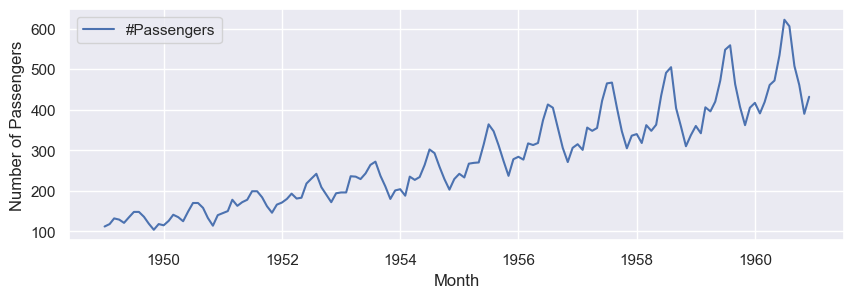

In [101]:
sns.lineplot(df)
plt.ylabel("Number of Passengers")

# Stationarity

In [102]:
rolling_mean = df.rolling(7).mean()
rolling_std = df.rolling(7).std()

In [103]:
rolling_mean 

,#Passengers
Month,
1949-01-01,NaN
1949-02-01,NaN
1949-03-01,NaN
1949-04-01,NaN
1949-05-01,NaN
...,...
1960-08-01,500.857143
1960-09-01,517.571429
1960-10-01,523.571429


In [104]:
rolling_std

,#Passengers
Month,
1949-01-01,NaN
1949-02-01,NaN
1949-03-01,NaN
1949-04-01,NaN
1949-05-01,NaN
...,...
1960-08-01,89.523607
1960-09-01,75.403044
1960-10-01,67.510140


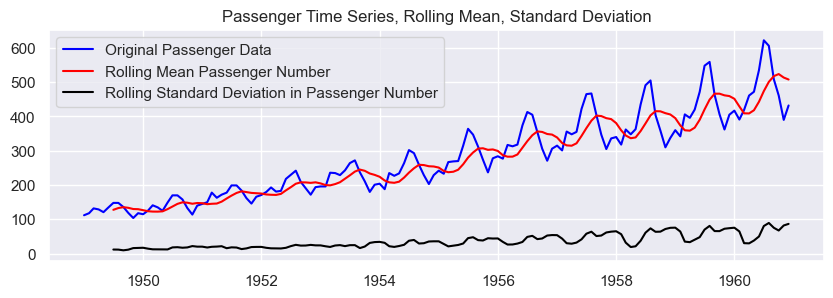

In [105]:
plt.plot(df, color="blue",label="Original Passenger Data")
plt.plot(rolling_mean, color="red", label="Rolling Mean Passenger Number")
plt.plot(rolling_std, color="black", label = "Rolling Standard Deviation in Passenger Number")
plt.title("Passenger Time Series, Rolling Mean, Standard Deviation")
plt.legend(loc="best")

In [106]:
from statsmodels.tsa.stattools import adfuller

In [107]:
adft = adfuller(df,autolag="AIC")
output_df = pd.DataFrame({"Values":[adft[0],adft[1],adft[2],adft[3], adft[4]['1%'], adft[4]['5%'], adft[4]['10%']]  , "Metric":["Test Statistics","p-value","No. of lags used","Number of observations used", 
                                                        "critical value (1%)", "critical value (5%)", "critical value (10%)"]})
print(output_df)

       Values                       Metric
0    0.815369              Test Statistics
1    0.991880                      p-value
2   13.000000             No. of lags used
3  130.000000  Number of observations used
4   -3.481682          critical value (1%)
5   -2.884042          critical value (5%)
6   -2.578770         critical value (10%)


**Так як р-value більше ніж 0.05 робимо висновок, що дані не стаціонарними.**

# Autocorrelation

In [108]:
autocorrelation_lag1 = df['#Passengers'].autocorr(lag=1)
print("One Month Lag: ", autocorrelation_lag1)

One Month Lag:  0.9601946480498522


In [109]:
autocorrelation_lag3 = df['#Passengers'].autocorr(lag=3)
print("Three Month Lag: ", autocorrelation_lag3)

autocorrelation_lag6 = df['#Passengers'].autocorr(lag=6)
print("Six Month Lag: ", autocorrelation_lag6)

autocorrelation_lag9 = df['#Passengers'].autocorr(lag=9)
print("Nine Month Lag: ", autocorrelation_lag9)

Three Month Lag:  0.837394765081794
Six Month Lag:  0.7839187959206183
Nine Month Lag:  0.8278519011167602


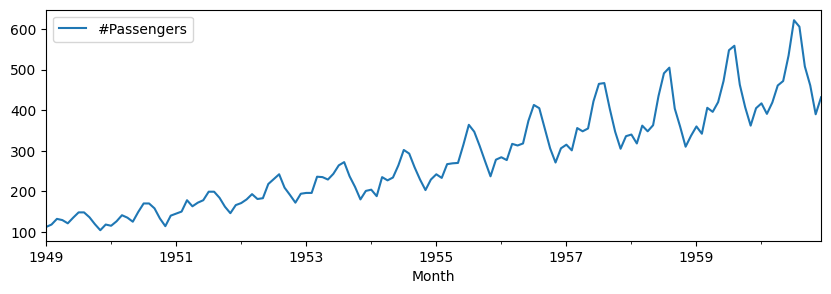

In [52]:
matplotlib.rcParams['figure.figsize'] = [10, 3]
df.plot()
plt.show()

In [110]:
acf_value = acf(df['#Passengers'])
acf_value

array([1.        , 0.94804734, 0.87557484, 0.80668116, 0.75262542,
       0.71376997, 0.6817336 , 0.66290439, 0.65561048, 0.67094833,
       0.70271992, 0.74324019, 0.76039504, 0.71266087, 0.64634228,
       0.58592342, 0.53795519, 0.49974753, 0.46873401, 0.44987066,
       0.4416288 , 0.45722376])

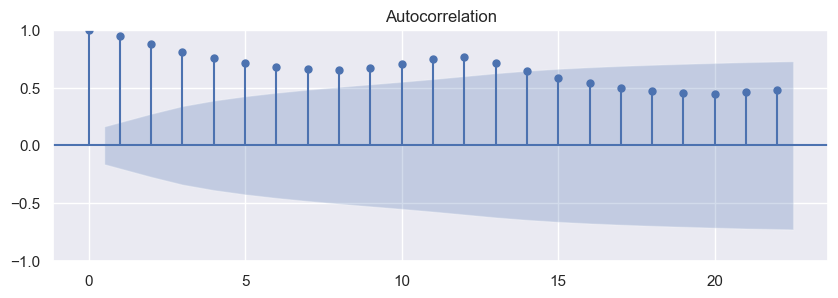

In [111]:
matplotlib.rcParams['figure.figsize']=[10,3]
plot_acf(df['#Passengers'])
pyplot.show()

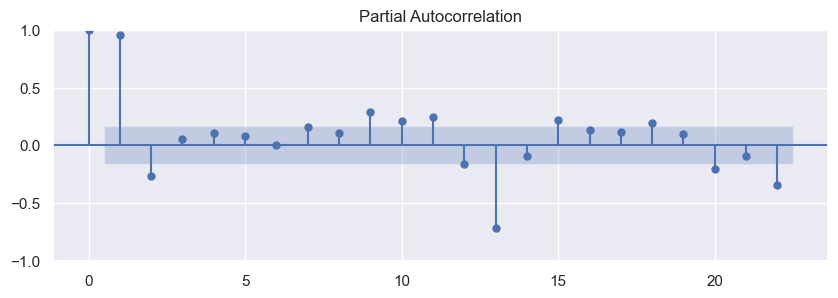

In [112]:
matplotlib.rcParams['figure.figsize']=[10,3]
plot_pacf(df['#Passengers'])
pyplot.show()

**Є замітна автокореляція.**

# Decomposition

In [113]:
from statsmodels.tsa.seasonal import seasonal_decompose

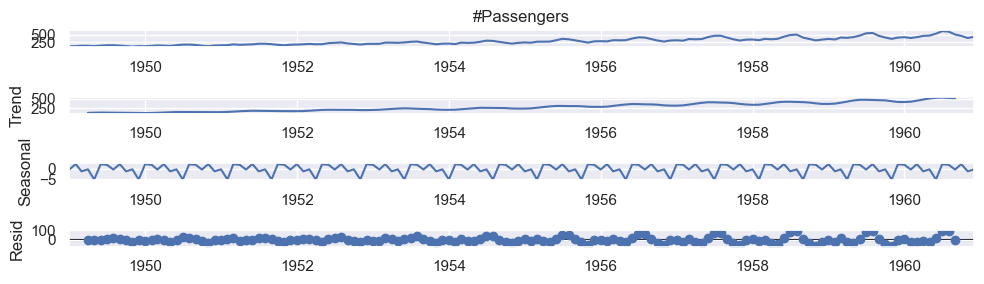

In [114]:
decompose = seasonal_decompose(df['#Passengers'],model='additive', period=7)
decompose.plot()
plt.show()

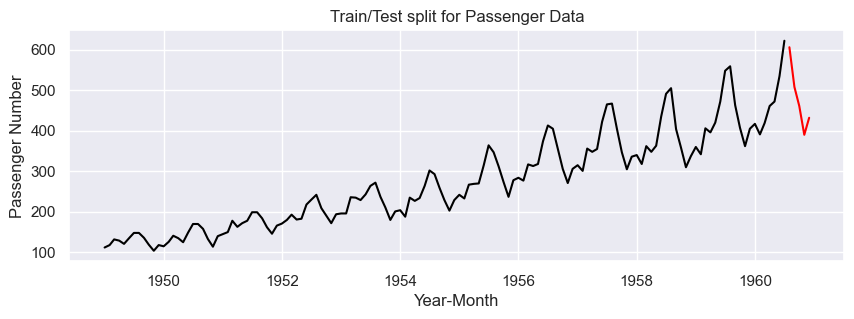

In [115]:
# df.index = np.datetime64(df.index)
df['Date'] = df.index
train = df[df['Date'] < pd.to_datetime("1960-08", format='%Y-%m')]
train['train'] = train['#Passengers']
del train['Date']
del train['#Passengers']
test = df[df['Date'] >= pd.to_datetime("1960-08", format='%Y-%m')]
del test['Date']
test['test'] = test['#Passengers']
del test['#Passengers']
plt.plot(train, color = "black")
plt.plot(test, color = "red")
plt.title("Train/Test split for Passenger Data")
plt.ylabel("Passenger Number")
plt.xlabel('Year-Month')
sns.set()
plt.show()

 # Forecasting with ARIMA

In [116]:
from pmdarima.arima import auto_arima
model = auto_arima(train, trace=True, error_action='ignore', suppress_warnings=True)
model.fit(train)
forecast = model.predict(n_periods=len(test))
forecast = pd.DataFrame(forecast,index = test.index,columns=['Prediction'])

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.26 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1352.593, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1340.702, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1336.259, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1352.415, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1329.986, Time=0.07 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=1335.098, Time=0.06 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=1336.923, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=1329.407, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=1335.407, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=1339.796, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=1325.560, Time=0.05 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=1336.3

In [117]:
forecast

,Prediction
Month,
1960-08-01,609.537779
1960-09-01,569.573023
1960-10-01,524.517128
1960-11-01,483.041416
1960-12-01,480.302296


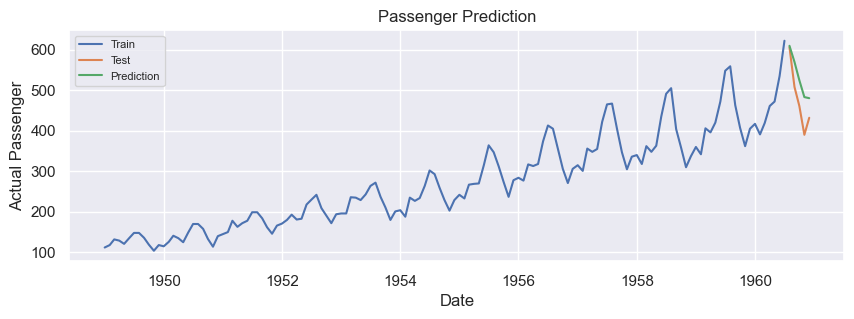

In [118]:
plt.plot(train, label='Train')
plt.plot(test, label='Test')
plt.plot(forecast, label='Prediction')
plt.title('Passenger Prediction')
plt.xlabel('Date')
plt.ylabel('Actual Passenger')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [133]:
from math import sqrt
from sklearn.metrics import mean_squared_error
rms = sqrt(mean_squared_error(test,forecast))
print("RMSE: ", rms)

RMSE:  61.36447741110699


In [134]:
import ml_metrics as metrics

In [135]:
metrics.mae(test, forecast)

53.99432831109145

In [136]:
metrics.rmse(test, forecast)

61.36447741110699

 # Forecasting with SARIMAX

In [244]:
model2 = auto_arima(train, seasonal=True, m=12)
model2.fit(train)
forecast2 = model2.predict(n_periods=len(test))
forecast2 = pd.DataFrame(forecast2,index = test.index,columns=['Prediction'])
# print(model.summary())
forecast2

,Prediction
Month,
1960-08-01,629.599295
1960-09-01,534.650640
1960-10-01,478.325612
1960-11-01,433.426096
1960-12-01,476.395031


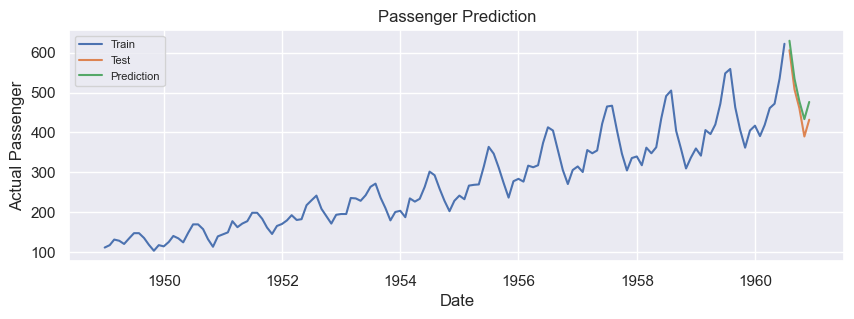

In [245]:
plt.plot(train, label='Train')
plt.plot(test, label='Test')
plt.plot(forecast2, label='Prediction')
plt.title('Passenger Prediction')
plt.xlabel('Date')
plt.ylabel('Actual Passenger')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [246]:
metrics.mae(test, forecast2)

31.079334664304884

In [247]:
metrics.rmse(test, forecast)

32.93662006480367

**Модель SARIMAX дає прийнятніші результати за рахунок врахування сезонності.**